# A three state model

Here's a simple model that captures the main idea of the package.
We use a three state model with three outputs. We can think of this setup as being a
ternary erasure channel, as shown in the diagram below.
![three_states](images/three_states.png)
We want to know whether or not there's an advantage in initial state discrimination for the given two-parameter model.

First we import all the relevant modules.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pyro
import pyro.distributions as dist
from bayes_perm_hmm.min_entropy_hmm import PermutedDiscreteHMM
from bayes_perm_hmm.sampleable import SampleableDiscreteHMM
from bayes_perm_hmm.util import id_and_transpositions, ZERO
from bayes_perm_hmm.simulator import Simulator

Now we define a function which generates the relevant HMMs. Note that we use the pyro distribution `dist.Categorical` to define the output distribution. In general, the output distributions should be chosen from the `pyro.distributions` library, using a distribution that has the `._param` attribute, and has `.has_enumerate_support = True`. For more details see the [pyro distributions documentation](http://docs.pyro.ai/en/0.2.1-release/distributions.html) as well as the [torch distributions documentation](https://pytorch.org/docs/stable/distributions.html) to see the available classes. If for some reason anything else fails, we can always revert to the `dist.Categorical` option.

It's important in the below function that we use a numerical `ZERO` which is not exactly zero, since all the computations take place in log space. This means that from the outset we will start taking logs of probabilities, so please make sure that all probabilities are nonzero.

In [2]:
num_states = 3
def gen_hmm(a, b, c=None, d=None, perms=False):
    if c is None:
        c = b
    if d is None:
        d = a
    initial_logits = (torch.ones(num_states)/num_states).log()
    output_dist = dist.Categorical(
        torch.tensor([[1-a-ZERO, a, ZERO], [(1-d)/2, d, (1-d)/2], [ZERO, a, (1-a)-ZERO]])
    )
    transition_logits = torch.tensor([[1-b-ZERO, b, ZERO],[(1-c)/2, c, (1-c)/2],[ZERO, b, 1-b-ZERO]]).log()
    if perms:
        possible_perms = id_and_transpositions(num_states)
        return PermutedDiscreteHMM(initial_logits, transition_logits, output_dist, possible_perms)
    else:
        return SampleableDiscreteHMM(initial_logits, transition_logits, output_dist)

Next, we make a data directory

In [3]:
import os
from datetime import datetime
today = datetime.now().strftime("%Y_%m_%d")
here = os.getcwd()
datadir = os.path.join(here, 'data/three_states/' + today)
if not os.path.exists(datadir):
    os.makedirs(datadir)

Here we generate data. The `Simulator` class is something that computes the outcomes of either all possible outcomes (by calling `.exact_simulation()` as done below), or samples the distribution generated by the HMM randomly (by calling `.empirical_simulation`). In either case, we compare the outcomes with those which would have happened in the absence of permutations. The `.exact_simulation()` method has exponential runtime in the number of timesteps (`num_timesteps` below), so please be advised that this is an expensive calculation for larger numbers of timesteps.

The object returned by the `exact_simulation` method has a trio of `..._postprocessor` objects in it. They each include the data required to perform postselection of the data on the figure
of merit relevant for the method of inference, a method to perform such postselection, and a `.misclassification_rates` method.

In [4]:
# Initialize the parameters
num_samp_a = 10
num_samp_b = 10
postprocessors = [[] for x in range(num_samp_a)]
n_rates = torch.empty(num_samp_a, num_samp_b)
b_rates = torch.empty(num_samp_a, num_samp_b)
i_rates = torch.empty(num_samp_a, num_samp_b)
a = torch.linspace(-1, -10, num_samp_a)
b = torch.linspace(-1, -10, num_samp_b)
num_timesteps = 6

In [5]:
# Generate the data (this may take a while)
for i in range(num_samp_a):
    for j in range(num_samp_b):
        phmm = gen_hmm(torch.exp(a[i]),
                       torch.exp(b[j]),
                       perms=True)
        # Any one of the three states are possible initial states which
        # we want to distringuish between, so we pass torch.arange(num_states)
        # as the `testing_states` parameter to the simulator.
        # We could also pass any subset of the states as argument to the simulator.
        s = Simulator(phmm, torch.arange(num_states), num_timesteps)
        # The below line trains the "interrupted" classifier, which performs likelihood
        # ratio tests assuming there are no transitions, terminating the inference procedure
        # if the ratio between the most likely state and the next most likely
        # state crosses a threshold. This method infers such an optimal threshold using brute
        # force search.
        _ = s.exact_train_ic()
        x = s.exact_simulation()
        with open(os.path.join(datadir, "timesteps_{}_a_{:.2e}_b_{:.2e}.pt".format(num_timesteps, a[i], b[j])), "wb") as f:
            torch.save(x.runs, f)
        # We want to keep just the Postprocessors in memory for later. The variable x contains
        # three Postprocessor classes, and the raw data as the last component.
        # The last component is bulky, so we'll just drop it.
        postprocessors[i].append(x[:-1])
        # The word "naive" here refers to the maximum a posteriori estimator of the initial state
        # using an HMM without permutations.
        all_n_rates = x.naive_postprocessor.misclassification_rates()
        all_b_rates = x.bayes_postprocessor.misclassification_rates()
        all_i_rates = x.interrupted_postprocessor.misclassification_rates()
        n_rates[i, j] = all_n_rates.average
        b_rates[i, j] = all_b_rates.average
        i_rates[i, j] = all_i_rates.average

The `x.*_postprocessor`s contain the data required to do postselection on the relevant figure of merit (the posterior initial state entropy in the case of the HMM with and without permutations, and the final likelihood ratio in the case of the "interrupted" classifier), a method to do so, and a `.misclassification_rates` method which computes the relevant misclassification rates.

Above, we store the `.average` attribute of the `all_*_rates` in the `*_rates` tensors. This quantity is $\mathrm{Pr}[S_0 \neq \hat{S}]$, where $\hat{S}$ is the inferred initial state. The other attribute, `.confusions`, of the `all_*_rates` objects include all the probabilities `all_*_rates.confusions[i, j]` $= \mathrm{Pr}[\hat{S} = j | S_0 = i]$.

Below, we plot the relative advantage of using permutations which (greedily) minimize expected posterior entropy. As we can see, the relative advantage of the protocol which uses permutations is largest when the errors are smallest. One can intuitively understand this as the memory of the initial state being kept the longest when the errors are small.

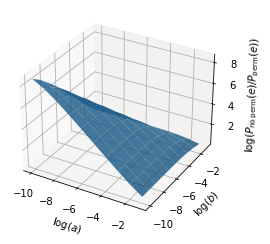

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y = np.meshgrid(a, b, indexing='ij')
log_ratios = ((n_rates).log() - (b_rates).log()).numpy()
surf = ax.plot_surface(x, y, log_ratios, alpha=.8)
ax.set_xlabel(r'$\log(a)$')
ax.set_ylabel(r'$\log(b)$')
ax.set_zlabel(r'$\log(P_{\mathrm{no\;perm}}(e)/P_{\mathrm{perm}}(e))$')
plt.show()

For comparison, below we see the individual log error rates.

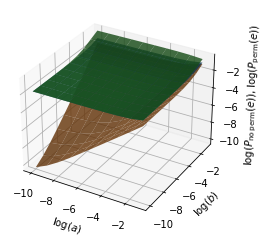

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, n_rates.log().numpy(), alpha=.8)
surfb = ax.plot_surface(x, y, b_rates.log().numpy(), alpha=.8)
surfi = ax.plot_surface(x, y, i_rates.log().numpy(), alpha=.8)
ax.set_xlabel(r'$\log(a)$')
ax.set_ylabel(r'$\log(b)$')
ax.set_zlabel(r'$\log(P_{\mathrm{no\;perm}}(e))$, $\log(P_{\mathrm{perm}}(e))$')
plt.show()

In the figure above, the two methods which do not involve permutations are indistinguishable.
There is a clear advantage to introducing permutations, which is due to being able
to move the fast decaying middle state to one of the outer states.

## Postselection

By choosing only the top 90% of runs, we can see whether the different methods of inference
diverge even further in their respective misclassification rates.
Here "top" is relative to the figure of merit relevant to that method of inference.
In the "interrupted" scheme, the runs are sorted according to the magnitude of the log likelihood ratio
between the largest likelihood and the next largest likelihood. In the two HMM schemes, this
figure of merit is the posterior initial state entropy, $H(S_1|Y^n)$.

Because we have computed all possible runs here, we can in fact select for the total remaining probability,
as opposed to simply selecting the best runs according to the different figures of merit.
This allows us to directly compare the error rates of the different methods, even in the postselected setting.
In an actual experiment using this protocol, this would correspond to collecting a large amount of data,
sorting the collected data by the figure of merit, then selecting a fixed portion of the best runs, as opposed to
the more natural alternative of simply discarding the runs which fail to meet a threshold figure of merit.

In [ ]:
n_post = torch.empty(num_samp_a, num_samp_b)
b_post = torch.empty(num_samp_a, num_samp_b)
i_post = torch.empty(num_samp_a, num_samp_b)
for i in range(num_samp_a):
    for j in range(num_samp_b):
        i_post[i, j] = postprocessors[i][j][0].postselected_misclassification(.9).average
        n_post[i, j] = postprocessors[i][j][1].postselected_misclassification(.9).average
        b_post[i, j] = postprocessors[i][j][2].postselected_misclassification(.9).average

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y = np.meshgrid(a, b, indexing='ij')
log_ratios = ((n_post).log() - (b_post).log()).numpy()
surf = ax.plot_surface(x, y, log_ratios, alpha=.8)
ax.set_xlabel(r'$\log(a)$')
ax.set_ylabel(r'$\log(b)$')
ax.set_zlabel(r'$\log(P_{\mathrm{no\;perm}}(e)/P_{\mathrm{perm}}(e))$')
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y,  n_post.log().numpy(), alpha=.8)
surfb = ax.plot_surface(x, y, b_post.log().numpy(), alpha=.8)
surfi = ax.plot_surface(x, y, i_post.log().numpy(), alpha=.8)
ax.set_xlabel(r'$\log(a)$')
ax.set_ylabel(r'$\log(b)$')
ax.set_zlabel(r'$\log(P_{\mathrm{no\;perm}}(e))$, $\log(P_{\mathrm{perm}}(e))$')
plt.show()



As we can see in the plots, the gain is even more pronounced in the case of postselected classification.


## Empirical misclassification rates

In the case that there are a large number of timesteps, it quickly becomes an intractible problem to
compute the exact misclassification rates. To obtain a good approximation, we can instead sample
from an HMM to generate data, then compute the classifier on a large number of such samples.

In [ ]:
# We have the same setup code as in the "exact" case.
postprocessors = [[] for x in range(num_samp_a)]
n_rates = torch.empty(num_samp_a, num_samp_b)
b_rates = torch.empty(num_samp_a, num_samp_b)
i_rates = torch.empty(num_samp_a, num_samp_b)
# This time we need to put the lower and upper limits
# of the confidence intervals somewhere.
n_lower = torch.empty(num_samp_a, num_samp_b)
b_lower = torch.empty(num_samp_a, num_samp_b)
i_lower = torch.empty(num_samp_a, num_samp_b)
n_upper = torch.empty(num_samp_a, num_samp_b)
b_upper = torch.empty(num_samp_a, num_samp_b)
i_upper = torch.empty(num_samp_a, num_samp_b)
a = torch.linspace(-1, -20, num_samp_a)
b = torch.linspace(-1, -20, num_samp_b)
num_timesteps = 15
"""
We need to train the InterruptedClassifier, but now we need to specify the number
of training samples to take. The samples will be drawn from the HMM without
permutations, with which we compute the misclassification rates under the
InterruptedClassifier at a large number of threshold likelihood ratios,
and similarly to the above, we pick the threshold to minimize the misclassification
rate on the training data.
"""
num_train = 200
# We also need to specify the number of samples to take for the computation of the
# misclassification rates.
num_samples = 1000
# We choose a 95% confidence interval.
confidence = .95

In [ ]:
for i in range(num_samp_a):
    for j in range(num_samp_b):
        phmm = gen_hmm(torch.exp(a[i]),
                       torch.exp(b[j]),
                       perms=True)
        s = Simulator(phmm, torch.arange(num_states), num_timesteps)
        _ = s.train_ic(num_train)
        x = s.empirical_simulation(num_samples, return_raw=False) # This time we just won't save the data
        postprocessors[i].append(x)
        # The word "naive" here refers to the maximum a posteriori estimator of the initial state
        # using an HMM without permutations.
        all_n_rates = x.naive_postprocessor.misclassification_rates(confidence)
        all_b_rates = x.bayes_postprocessor.misclassification_rates(confidence)
        all_i_rates = x.interrupted_postprocessor.misclassification_rates(confidence)
        n_rates[i, j], (n_lower[i, j], n_upper[i, j]) = all_n_rates.average
        b_rates[i, j], (b_lower[i, j], b_upper[i, j]) = all_b_rates.average
        i_rates[i, j], (i_lower[i, j], i_upper[i, j]) = all_i_rates.average

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y = np.meshgrid(a, b, indexing='ij')
surf = ax.plot_surface(x, y, n_rates.log().numpy(), alpha=.8)
ax.set_xlabel(r'$\log(a)$')
ax.set_ylabel(r'$\log(b)$')
ax.set_zlabel(r'$\log(P_{\mathrm{no\;perm}}(e)/P_{\mathrm{perm}}(e))$')
plt.show()

Because the calculations are not exact, we can also look for the associated confidence regions

In [ ]:
fig = plt.figure()
ax = fig.gca()
ax.errorbar(a, n_rates[:, 5].log().numpy(), torch.stack([-n_lower[:, 5].log() + n_rates[:, 5].log(), n_upper[:, 5].log() - n_rates[:, 5].log()]).numpy())
ax.set_xlabel("a")
ax.set_ylabel(r"$\log(P_{\mathrm{no\!perm}})$")
plt.title(r"$b = {:.2e}$".format(b[5]))
plt.show()

Because of the nature of the model, we can sometimes have an empirical error rate of 0 from this model.
This will cause errors if we try to plot it on a log scale. To account for this quirk, we'll just set
the values which are zero to some small number instead.

In [ ]:
b_lower[b_lower.isclose(torch.tensor(0.))] = ZERO
b_rates[b_rates.isclose(torch.tensor(0.))] = ZERO
fig = plt.figure()
ax = fig.gca()
ax.errorbar(a, b_rates[:, 5].log().numpy(), torch.stack([-b_lower[:, 5].log() + b_rates[:, 5].log(), b_upper[:, 5].log() - b_rates[:, 5].log()]).numpy())
ax.set_ylim([-7, -1])
ax.set_xlabel("a")
ax.set_ylabel(r"$\log(P_{\mathrm{perm}})$")
plt.title(r"$b = {:.2e}$".format(b[5]))
plt.show()

We see a clear advantage here, as well.


### Loading data

Loading data is straightfoward:

In [ ]:
fns = os.listdir(datadir)
with open(os.path.join(datadir, fns[0]), "rb") as f:
    x = torch.load(f)

In [ ]:
x

